In [2]:
import ast
import os
import glob
import numpy as np
import datetime
import xarray as xr
import nc_time_axis
import itertools
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cftime
%matplotlib inline

In [3]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}

ds = {exp: [] for exp in open_kwargs}
for exp, (name, year, tag) in open_kwargs.items():
    maxtn = 0
    num_days = 0
    for n in range(1,6):
        fname = f'{name}.started_{year}.00{n}/TC_tracker_results.{tag}.started_{year}.00{n}.nc'
        if os.path.exists(fname):
            dsi = xr.open_dataset(fname, decode_cf=False)
            # # test start
            # for tid in dsi.id.data:
            #     lons = dsi.TC_tracks.isel(data=1).sel(id=tid)
            #     lons[lons>1e30] = np.nan
            #     if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            #         print(exp, n, tid, lons.values[5:10])
            # # test end
            dsi = (dsi.assign_coords(id=('id',dsi.id.data+maxtn,dsi.id.attrs))
                   .assign_coords(ens=('id',np.ones(dsi.id.size)*n,{'long_name':'ensemble member'})))
            ds[exp].append(dsi)
            maxtn = dsi.id.max().item()
            times = dsi.TC_tracks.isel(data=0)
            num_days += dsi.num_days
            print(f'{tag.upper()}.00{n}: {dsi.num_days/365:.3f} years, {len(dsi.id)} tracks')
    ds[exp] = xr.concat(ds[exp], data_vars='minimal', dim='id')
    ds[exp]['num_days'] = num_days.assign_attrs({'long_name':'total number of analysed days'})


for k,v in ds.items():
    for i,(desc) in enumerate(v.data.description):
        shortname = desc[:desc.index(':')]
        v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
            ast.literal_eval(desc[desc.index(':')+1:]))
        v[shortname].data[v[shortname]>1e30] = np.nan
    time = v.time.copy()
    tmask = np.isnan(time)
    time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    v['year'] = time.dt.year.where(~tmask, np.nan)
    v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
    v['PRECT'].attrs.update({'units':'mm/hour'})


# There are a handful of NaNs in longitude in otherwise fine trajectories
# fixing manually...
for exp in ds:
    for tid in ds[exp].id.data:
        dsi = ds[exp].sel(id=tid)
        if np.isnan(dsi.lon[7]):
            dsi.lon[7] = dsi.lon[6]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=7 to {dsi.lon.data[6]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon
        if np.isnan(dsi.lon[8]):
            dsi.lon[8] = dsi.lon[9]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=8 to {dsi.lon.data[9]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon

REF.001: 5.000 years, 478 tracks
REF.002: 5.000 years, 485 tracks
REF.003: 5.000 years, 495 tracks
REF.004: 5.000 years, 499 tracks
REF.005: 5.000 years, 521 tracks
RCP.001: 5.000 years, 447 tracks
RCP.002: 5.000 years, 438 tracks
RCP.003: 5.000 years, 465 tracks
RCP.004: 5.000 years, 465 tracks
RCP.005: 5.000 years, 457 tracks
SAI.001: 5.000 years, 426 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 413 tracks
SAI.004: 5.000 years, 433 tracks
SAI.005: 5.000 years, 405 tracks
Reference tid=585.0: changing lon=NaN at dtime=7 to 100.312
Reference tid=585.0: changing lon=NaN at dtime=8 to 100.000
Reference tid=790.0: changing lon=NaN at dtime=7 to 100.625
Reference tid=858.0: changing lon=NaN at dtime=8 to 99.062
Reference tid=1158.0: changing lon=NaN at dtime=7 to 100.312
Reference tid=1158.0: changing lon=NaN at dtime=8 to 100.000
Reference tid=1191.0: changing lon=NaN at dtime=7 to 100.312
Reference tid=2087.0: changing lon=NaN at dtime=7 to 100.000
SAI2050 tid=154.0: cha

In [4]:
# Print any remaining unexpected NaNs...
for exp in ds:
    for tid in ds[exp].id.data:
        lons = ds[exp].lon.sel(id=tid)
        if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            print(exp, n, tid, lons.values[:])

In [5]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='RCP8.5'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI2050'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='RCP-Ref'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI-Ref'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI-RCP'),
}

domains = {k:sgeom.Polygon(v) for k,v in {
    'NA': ((-65,0),(-100,20),(-100,60),(0,60),(0,0)),
    'SA': ((-65,-60),(-65,0),(25,0),(25,-60)),
    'ENP':((-180,0),(-180,60),(-100,60),(-100,20),(-65,0)),
    'WNP':((100,0),(100,60),(180,60),(180,0)),
    # 'ESP':((-180,-60),(-180,0),(-65,0),(-65,-60)),
    # 'WSP':((130,-60),(130,0),(180,0),(180,-60)),
    'SP': ((130,-60),(130,0),(295,0),(295,-60)), # last point only needed for plotting purposes
    'NI': ((40,0),(40,30),(100,30),(100,0)),
    'SI': ((25,-60),(25,0),(130,0),(130,-60)),
}.items()}


def track_stat(ds, method='min'):
    """Reduce dataset along dtime dimension through various methods.
    
    method:
        min: minimum
        max: maximum
        minmax: minimum for pressure, RMW and shear, else maximum
        mean: mean
        maxRV: maximum relative vorticity
        maxdeep: maximum 12h deepening
        develop: until maximum relative vorticity
    """
    match method:
        case 'min': # minimum along track
            out = ds.min('dtime', keep_attrs=True)
        case 'max': # maximum along track
            out = ds.max('dtime', keep_attrs=True)
        case 'minmax': # minimum for pressure/RMW/shear, else maximum
            minvars = ['PSL','PSLmon','RMW','Vshear']
            dsc = ds.copy()
            dsc[minvars] = ds[minvars].min('dtime', keep_attrs=True)
            out = dsc.max('dtime', keep_attrs=True)
        case 'mean':
            out = ds.mean('dtime', keep_attrs=True)
        case 'maxRV': # maximum relative vorticity
            out = ds.isel(dtime=ds.RV.argmax('dtime'))
        # case 'maxdeep': # max 12 hour (= 4x3hr) deepening
        #     pres = ds.pres.transpose(...,'track_time')
        #     dpres = xr.ones_like(pres[...,2:-2])*(pres.data[...,4:]-pres.data[...,:-4])
        #     times = dpres.track_time.isel(track_time=dpres.argmin('track_time'))
        #     return ds.sel(track_time=times)
        case 'maxdeep': # max 12 hour (= 4x3hr) deepening
            pres = ds.PSL.transpose(...,'dtime')
            dpres = xr.ones_like(pres[...,2:-2])*(pres.data[...,4:]-pres.data[...,:-4])
            tt = dpres.argmin('dtime')
            ttmin = (tt-2).clip(min=0)
            ttmax = (tt+2).clip(max=len(ds.dtime))
            TTmin = ds.dtime.isel(dtime=ttmin)
            TTmax = ds.dtime.isel(dtime=ttmax)
            numdays = ds.num_days
            ds = (ds.where(ds.dtime>=TTmin, np.nan)
                  .where(ds.dtime<=TTmax, np.nan)
                  .mean('dtime', keep_attrs=True))
            ds['num_days'] = numdays
            out = ds
        case 'develop': # time mean from start to max. rel. vorticity
            times = ds.dtime.isel(dtime=ds.RV.argmax('dtime'))
            numdays = ds.num_days
            ds = ds.where(ds.dtime<=times, np.nan).mean('dtime', keep_attrs=True)
            ds['num_days'] = numdays
            out = ds
    out = out.set_coords('year')
    return out


def cum_prob_density(data, reverse=False):
    """Cumulative probability density of flattened data"""
    data = data.stack(x=[...]).dropna('x')
    if reverse:
        sorted = np.sort(data, axis=None)[::-1]
    else:
        sorted = np.sort(data, axis=None)
    return xr.DataArray(
        data = np.arange(data.size) / (data.size-1),
        coords = [(data.name, sorted, data.attrs)])


def prob_density(data, n=50):
    xchunks = np.array_split(np.sort(data), len(data)/n)
    for x,xs in enumerate(xchunks[:-1]):
        xchunks[x] = np.append(xchunks[x], xchunks[x+1][0])
    xfirst = [xs[0] for xs in xchunks]
    xwidths = [xs[-1]-xs[0] for xs in xchunks]
    xdiff = [(len(x)-1)/(x[-1]-x[0])/ds[exp].num_days*365 for x in xchunks]
    return xfirst, xdiff, xwidths


def prob_density(data, n=50):
    data = np.sort(data)
    x = data[n//2:-n//2]
    return x, n/(data[n:]-data[:-n])
    

def track_density(ds, xbins=range(0,361,4), ybins=range(-90,91,4)):
    dsi = ds[['lon','lat']]
    if 'dtime' in dsi.dims:
        dsi = dsi.isel(id=0).dropna('dtime', how='all')
        hist, hlon, hlat = np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))
        hist = hist.clip(max=1)
        for tn in ds.id[1:]:
            dsi = ds.sel(id=tn).dropna('dtime', how='all')
            hist += np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))[0].clip(max=1)
    else:
        hist, hlon, hlat = np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))
    hist[hist==0] = np.nan
    hist = hist/ds.num_days.data*365
    return hlon, hlat, hist.T


def TChoursperday(ds):
    """Calculate total TC hours per day in dataset ds"""
    out = {}
    for ens in np.unique(ds.ens):
        dsi = ds.where(ds.ens==ens, drop=True)#.dropna('id',how='all')
        times_in = dsi.time.stack(x=[...]).dropna('x')
        times_out = np.arange(times_in.min(), times_in.max()+.1, 0.125)
        out[ens] = xr.DataArray(data=np.zeros(times_out.size), 
            coords={'time':('time',times_out,dsi.time.attrs)},
            name='freq', attrs={'long_name':'TC frequency','units':'TC hours per day'})
        vals, counts = np.unique(times_in, return_counts=True)
        out[ens][np.searchsorted(out[ens].time, vals)] = counts*3
        out[ens] = xr.decode_cf(out[ens].to_dataset()).freq
    out = xr.concat(out.values(), 'ens', fill_value=0)
    out['ens'] = out.ens + 1
    out = out.coarsen(time=8).sum()
    return out


def assign_dayofyear(ds):
    """Split along time into year and dayofyear dimension"""
    assert 'time' in ds.coords, "time must be a coordinate"
    assert ds.time.ndim == 1, "time must be one-dimensional"
    if not hasattr(ds.time, 'dt'):
        ds = xr.decode_cf(ds, decode_timedelta=True)
    result = []
    for year in np.unique(ds.time.dt.year):
        dsi = ds.sel(time=str(year)).drop_vars('year',errors='ignore')
        dsi = (dsi.assign_coords(time=dsi.time.dt.dayofyear)
               .rename({'time':'dayofyear'})
               .expand_dims('year'))
        result.append(dsi)
    return xr.concat(result, dim='year', join='exact')


def cyclical_rollmean(da:xr.DataArray, dim:str, w:int):
    """Apply rolling mean along cyclical dimension

    da : DataArray to apply rolling mean to
    dim : name of dimension along which to apply rolling mean
    w : window size (int)
    """
    sid = w//2
    da_x = xr.concat((
        da.isel({dim:slice(da[dim].size-sid,None)}),
        da,
        da.isel({dim:slice(None,sid)})
    ), dim=dim)
    result = da_x.rolling({dim:w}, center=True).mean(keep_attrs=True)
    result = result.isel({dim:slice(sid,da_x[dim].size-sid)})
    return result


def rolling_rolling(ds, n, rolldim, dim):
    """Expand dimensions of dataset ds by rolling the data n times
    along rolldim within a centered window of size n. Adds dimension dim.
    """
    shifts = range(n//2-n+1,n//2+1) # centered window of size n
    rolled = [ds.roll({rolldim: shift}).expand_dims(dim) for shift in shifts]
    return xr.concat(rolled, dim=dim)


def get_domain(lon, lat):
    lon = (lon + 180)%360 - 180 # convert to -180,180 range
    p = sgeom.Point(lon, lat)
    for dom in domains:
        if domains[dom].contains(p) or p.touches(domains[dom]):
            return dom
    # retry for the 180-540 range (useful for SP)
    p = sgeom.Point(lon+360, lat)
    for dom in domains:
        if domains[dom].contains(p) or p.touches(domains[dom]):
            return dom
    return None


def fix_longitude_jumps(lons, thresh=10):
    """Remove longitude jumps when crossing the Greenwich Meridian
    
    lons (1-d): longitudes
    thresh : maximum expected absolute longitude change per step
    """
    newlons = np.array(lons, copy=True)
    if any(np.abs(np.diff(lons))>thresh):
        for l in range(1,len(newlons)):
            dlon = newlons[l] - newlons[l-1]
            inc = np.sign(int(abs(dlon)>thresh) * dlon)
            if inc != 0:
                newlons[l] = newlons[l] - inc * 360
    return newlons


def track_segments(ds, clevs, x='lon', y='lat', c='PSL', reverse=True):
    """Split all tracks in ds into segments of equal intensity

    input:
    ds : xr.Dataset
        the dataset containing TC tracks
    clevs : Iterable[Numeric]
        levels (bin edges) used to discretize 'c' and segment track data
    x : str
        name of longitude variable
    y : str
        name of latitude variable
    c : str
        name of variable that will be used to segment the track data
    reverse : bool
        by default, track segments having lower values of 'c' are
        output first, this can be reversed by setting reverse=True

    returns:
    """
    ds = ds[[x,y,c]]
    cvals = 0.5 * (clevs[1:] + clevs[:-1])
    
    segments = []
    for tid in ds.id.data:
        # remove longitude jumps when crossing the Greenwich Meridian
        track = ds.sel(id=tid).dropna('dtime')
        track[x].data = fix_longitude_jumps(track[x].data)
        
        # groupby color level consecutively along track
        clev_ids = np.searchsorted(clevs, track[c])
        comb = zip(clev_ids, track[x].data, track[y].data)
        gb = itertools.groupby(comb, key=lambda x: x[0])
        track_segs = [[k,np.vstack(list(dt))[:,1:]] for k,dt in gb]
    
        # insert midway points for smooth joins of segments
        for s,(seg1, seg2) in enumerate(itertools.pairwise(track_segs)):
            ival = np.mean([seg1[1][-1],seg2[1][0]], axis=0)
            track_segs[s][1] = np.vstack([track_segs[s][1], ival])
            track_segs[s+1][1] = np.vstack([ival,track_segs[s+1][1]])
        
        segments += track_segs
    
    segments = sorted(segments, key=lambda x:x[0], reverse=reverse)
    gb = itertools.groupby(segments, key=lambda x:x[0])
    segments = {c:[segs for _,segs in grp] for c,grp in gb}
    return segments


def histogram(da, bins=np.arange(900,1015,2.5)):
    """compute histogram of da for all available ensembles and years

    input:
    da : xr.DataArray
        data to compute histogram of
    bins : Iterable[Numeric]
        bin edges used to digitize the data

    returns: xr.Dataset
        the histogram count (hcount), bin edges and central bin values
    """
    assert 'dtime' not in da.dims, "da must first be reduced, e.g. using track_stat()"
    ensembles = np.unique(da.ens)
    years = np.unique(da.year)
    data = []
    for ens in ensembles:
        ensdata = []
        for year in years:
            da_i = da.where((da.ens==ens) & (da.year==year), drop=True)
            if da_i.id.size == 0:
                continue
            hist,bins = np.histogram(da_i, bins)
            hist = xr.DataArray(
                hist,
                name = 'hcount',
                coords = {'ens':da_i.ens.isel(id=0, drop=True), 
                          'year':da_i.year.isel(id=0, drop=True), 
                          'bins':('bins',(bins[1:]+bins[:-1])/2,{'units':da.units})}, 
                dims='bins',
                attrs={'long_name':'histogram of '+getattr(da, 'long_name', da.name)},
            )
            ensdata.append(hist)
        data.append(xr.concat(ensdata, dim='year'))
    hist = xr.concat(data, dim='ens')
    bin_edges = xr.DataArray(bins, name='bin_edges', dims='bin_edges', attrs={'units':da.units})
    return xr.Dataset({'hcount':hist, 'bin_edges':bin_edges})


def plot_histogram(ax, hists, exps=None, yunits=''):
    """make fancy histogram (difference) plot
    
    input:
    ax : matplotlib.axes.Axes
        axis to draw
    hists : dict[str,xr.Dataset]
        mapping from experiment name to Dataset containing histogram data
        Dataset is generally the output of histogram()
    exps : List[[str]
        names of experiments to plot (which must be in hists). It is possible
        to provide a list of size one with two experiments separated by a dash (-),
        in which case the difference of these experiments is plotted.
    yunits : str
        the y-axis units of a difference plot. If 'se' (not case-sensitive), the difference
        is shown in units of the combined standard error of the two datasets.

    returns:
        axis instance on which the plot is drawn
    """
    if exps is None:
        exps = list(hists.keys())
    if '-' not in exps[0]: # regular histograms
        for exp in exps:
            hist = hists[exp]
            ydata = hist.hcount.stack(x=['ens','year']).mean('x')
            ax.stairs(ydata, hist.bin_edges, fill=False, zorder=3, **default_kwargs[exp])
            binsize = (hist.bin_edges[1]-hist.bin_edges[0]).item()
            ax.set_title(f"bin={round(binsize,4)}", loc='right')
            ax.grid()
    elif '-' in exps[0]: # histogram difference plot
        for exp in exps:
            exp2, exp1 = exp.split('-')
            hist1 = hists[exp1].stack(x=['ens','year'])
            hist2 = hists[exp2].stack(x=['ens','year'])
            xdata = hist1.bins
            ydata = (hist2.hcount.mean('x') - hist1.hcount.mean('x'))
            wdata = hist1.bin_edges.data[1:] - hist1.bin_edges.data[:-1]
            stderr1 = hist1.hcount.std('x', ddof=1) / np.sqrt(hist1.hcount.x.size)
            stderr2 = hist2.hcount.std('x', ddof=1) / np.sqrt(hist2.hcount.x.size)
            stderr = np.sqrt(stderr1**2 + stderr2**2)/np.sqrt(2)
            # mask = (hist1.hcount.sum('x')>=5) & (hist2.hcount.sum('x')>=5)
            mask = (hist1.hcount.sum('x') + hist2.hcount.sum('x')) >= 10
            if yunits.lower() == 'se':
                ydata = ydata / stderr
                ax.set_ylim([-4,4])
                ax.set_yticks(range(-4,5), minor=True)
                ax.set_yticks(range(-4,5,2), minor=False)
                ax.grid(visible=True, which='minor', axis='y')
            else:
                segments = [np.column_stack([hist1.bins, stderr*i]) for i in range(-3,4)]
                ax.add_collection(LineCollection(segments, color='k', lw=0.5, zorder=4), autolim=False)
            ax.grid()
            ydata_pos = np.where((ydata >= 0) & mask, ydata, np.nan)
            ydata_neg = np.where((ydata < 0) & mask, ydata, np.nan)
            ydata_inv = np.where(~mask, ydata, np.nan)
            kwargs = default_kwargs[exp].copy()
            kwargs.pop('color')
            dh1 = ax.bar(xdata, ydata_pos, wdata, edgecolor=None, fill=True, zorder=3, color='orange', **kwargs)
            dh2 = ax.bar(xdata, ydata_neg, wdata, edgecolor=None, fill=True, zorder=3, color='lightgreen', **kwargs)
            dh3 = ax.bar(xdata, ydata, wdata, edgecolor='k', lw=1, fill=False, zorder=3)     
    return ax


def select_region(ds, region, method='maxRV'):
    """Select tracks in a specific region

    ds : xr.Dataset
        dataset containing the track data
    region : str [GLOB,NH,SH] or any key in 'domains'
        name of region
    method : str
        reduction method applied before region checking
        passed on to track_stat()

    returns : xr.Dataset
        dataset containing only the tracks that
        occur in the selected region
    """
    if 'dtime' in ds.dims:
        ds_ts = track_stat(ds, method)
    else:
        ds_ts = ds
    match region:
        case 'GLOB':
            return ds
        case 'NH':
            return ds.where(ds_ts.lat>=0, drop=True)
        case 'SH':
            return ds.where(ds_ts.lat<0, drop=True)
            
    ds['domain'] = ('id',[get_domain(lon, lat) for lon,lat in zip(ds_ts.lon, ds_ts.lat)])
    return ds.where(ds.domain==region, drop=True).drop_vars('domain')


def savefig(fig, fname, **kwargs):
    """calls fig.savefig(fname, **kwargs) only if fname does not exist"""
    if os.path.exists(fname):
        print(f"{fname} already exists, cannot overwrite")
    else:
        print(f"saving {fname}...")
        fig.savefig(fname, **kwargs)


def bootstrap(data, func, *args, n=10000, qs=(0.05,0.95), **kwargs):
    """statistical bootstrapping for significance testing
    
    data : arraylike (1D)
        data to apply bootstrapping on
    func : function
        function that returns a scalar statistic on the data, e.g. mean, median, quantile
    n : int
        number of times to resample the data
    qs : arraylike of float [0-1]
        quantile values of the statistic that are returned by this function
        with default qs, the 90% confidence interval (0.05,0.95) is returned
    args, kwargs : (keyword) arguments
        are passed on to func

    returns : np.array
        quantile values of the statistics as calculated by func on all 
        n resampled datasets
    """
    data = np.array(data)
    assert data.ndim == 1, "data must be one-dimensional"
    stat = func(data, *args, **kwargs)
    try:
        stat = np.array(stat).item()
    except ValueError:
        print(f"stat must be a scalar, but has shape {np.array(stat).shape}")
        raise
    cdata = data - stat
    ids = np.random.randint(data.size, size=(n, data.size))
    data_bs = cdata[ids] # create n samples
    stats = np.array([func(s, *args, **kwargs) for s in data_bs])
    stats += stat
    return np.quantile(stats, qs)

figures/tracks.pdf already exists, cannot overwrite
CPU times: user 11.7 s, sys: 177 ms, total: 11.9 s
Wall time: 12.1 s


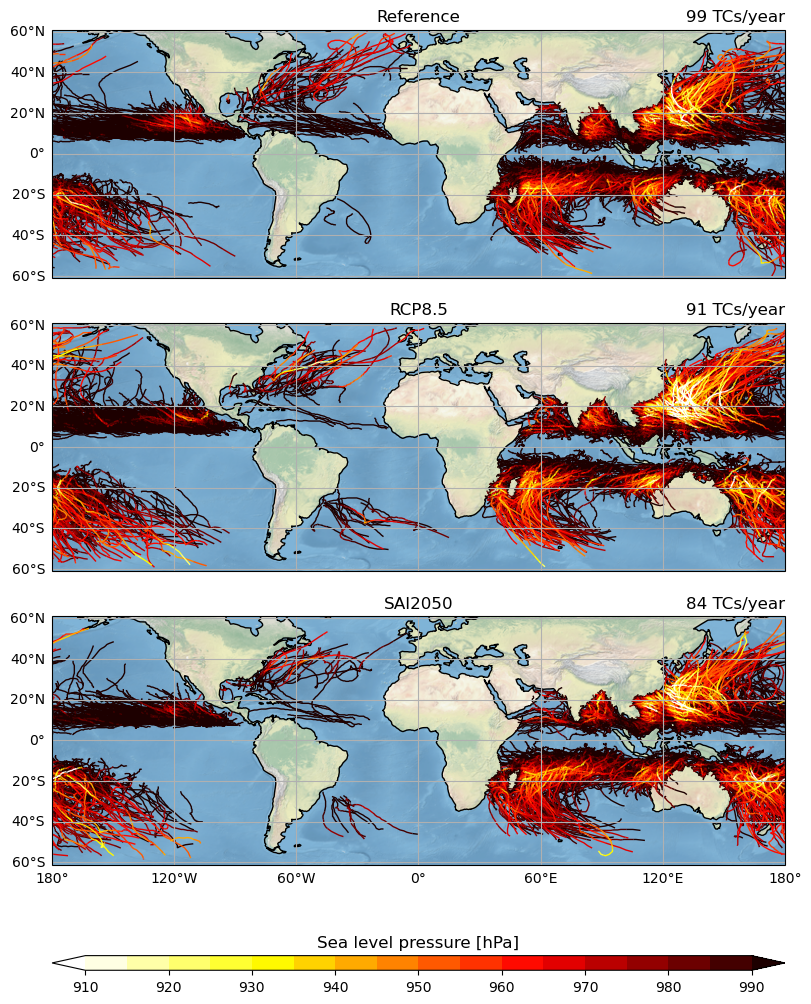

In [5]:
%%time
fname = 'figures/tracks.pdf'
vmin, vmax, Nv = 910, 990, 17
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')
extent = (-180,180,-61,61) # (x0, x1, y0, y1)

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for exp, ax in zip(ds, axs):
    segments = track_segments(ds[exp], clevels)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title(exp)
    ax.set_title(f'{ds[exp].id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.stock_img()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50)
cb.ax.set_title('Sea level pressure [hPa]')

savefig(fig, fname, transparent=True, bbox_inches='tight')

In [6]:
# create annual mean and variance of NH/SH daily TC hours
ydata_NH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_NH = ds[exp].where(lats>0).dropna('id', how='all')
    ydata = assign_dayofyear(TChoursperday(ds_NH))
    ydata = ydata.roll(dayofyear=-90, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_NH[exp] = ydata

ydata_SH = {}
for exp in ds:
    lats = ds[exp].isel(dtime=0).lat
    ds_SH = ds[exp].where(lats<=0).dropna('id', how='all')
    ydata = assign_dayofyear(TChoursperday(ds_SH))
    ydata = ydata.roll(dayofyear=154, roll_coords=True)
    ydata['doy'] = ('dayofyear', np.array(range(365))+ydata.dayofyear[0].item()) # monotonically increasing doy needed for plotting
    ydata_SH[exp] = ydata

saving figures/TC_count_NH_SH.pdf...


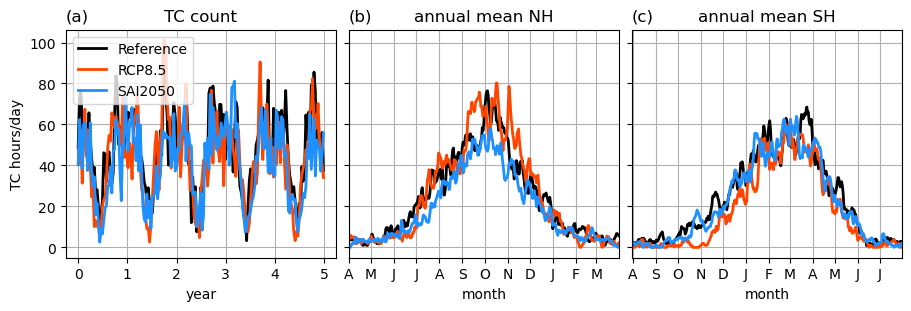

In [8]:
figname = 'figures/TC_count_NH_SH.pdf'

fig, axs = plt.subplots(1,3, figsize=(9,3), sharey=True, layout='constrained')

ax = axs[0]
for exp in ds:
    ydata = TChoursperday(ds[exp])
    ydata = ydata.resample(time='10D').mean()
    ydata['time'] = ydata.time - cftime.DatetimeNoLeap(ydata.time[0].dt.year,1,1)
    ax.plot(ydata.time.dt.total_seconds()/86400/365, ydata.mean('ens'), **default_kwargs[exp])
t = ax.set_title("TC count")
ax.set_title('(a)', loc='left')
ax.set_xlabel("year")
ax.legend()
ax.grid()
ax.set_ylabel("TC hours/day")

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

ax = axs[1]
for exp in ds:
    ydata = ydata_NH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean NH")
ax.set_title("(b)", loc='left')
ax.set_xlabel("month")
ax.grid()

ax = axs[2]
for exp in ds:
    ydata = ydata_SH[exp]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax.plot(ydata.doy, ydata.mean(('ens','year')), **default_kwargs[exp])
ax.set_xticks(ydata.doy[ids], xticklabs)
ax.set_xlim((ydata.doy.min(),ydata.doy.max()))
t = ax.set_title("annual mean SH")
ax.set_title("(c)", loc="left")
ax.set_xlabel("month")
ax.grid()

savefig(fig, figname, transparent=True, bbox_inches='tight')

Daily sum of TC hours, i.e. the track duration on any given day summed over all active tracks. a) shows the ensemble mean daily sum of TC hours, smoothed by a 10-day running mean, b) and c) show the ensemble mean interannual mean daily sum of TC hours for the Northern and Southern Hemisphere, respectively.

In [9]:
n = 20 # window size (centered) along dayofyear

ydata_NHMA = {exp:rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_NH.items()}
ydata_SHMA = {exp:rolling_rolling(ydata, n, 'dayofyear', 'ddoy').stack(x=['ens','year']) 
              for exp,ydata in ydata_SH.items()}

# calculate rolling window mean and standard error 
ydata_NHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_NHMA.items()}
ydata_SHMA = {exp: (ydata.mean(('x','ddoy'), keep_attrs=True), ydata.std('x', ddof=1, keep_attrs=True).mean('ddoy', keep_attrs=True)/np.sqrt(ydata.x.size))
             for exp,ydata in ydata_SHMA.items()}

saving figures/TC_count_NH_SH_diff.pdf...


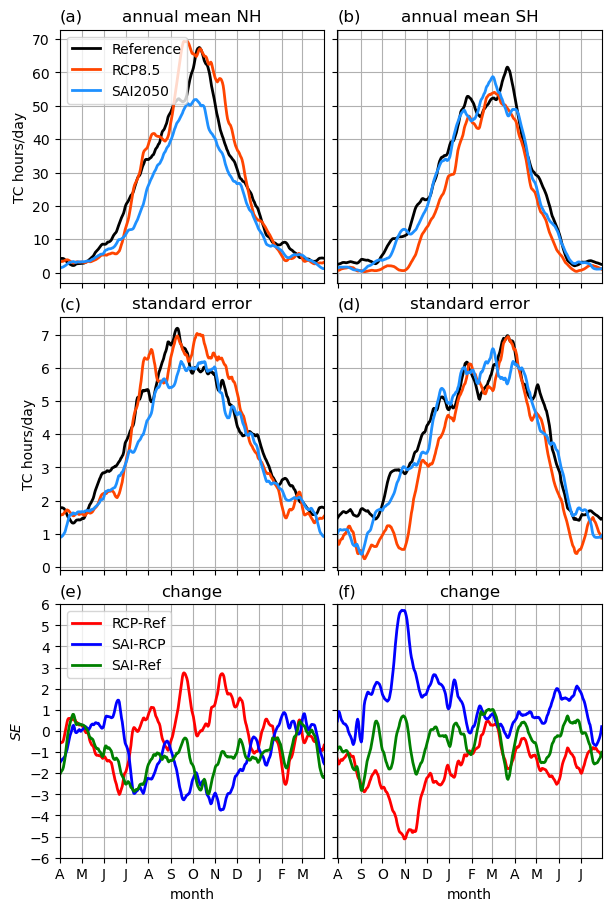

In [10]:
fname = 'figures/TC_count_NH_SH_diff.pdf'
fig, axs = plt.subplots(3,2, figsize=(6,9), sharex='col',sharey='row', layout='constrained')

xticks = np.array([0,31,59,90,120,151,181,212,243,273,304,334]) + 1
xticklabs = ['J','F','M','A','M','J','J','A','S','O','N','D']

for ax, plot_data in zip([axs[:,0],axs[:,1]],[ydata_NHMA,ydata_SHMA]):
    ydata = plot_data['Reference'][0]
    ids = [np.abs(ydata.dayofyear-xt).argmin().item() for xt in xticks]
    ax[0].set_xticks(ydata.doy[ids], xticklabs)
    ax[0].set_xlim((ydata.doy.min(),ydata.doy.max()))
    for exp,ydata in plot_data.items():
        y_mean, y_se = ydata
        ax[0].plot(y_mean.doy, y_mean, **default_kwargs[exp])
        ax[1].plot(y_se.doy, y_se, **default_kwargs[exp])
    
    ax[2].set_yticks(range(-6,7))
    ax[2].set_ylim([-6,6])
    for exps in ['RCP8.5-Reference','SAI2050-RCP8.5','SAI2050-Reference']:
        exp2, exp1 = exps.split('-')
        y_mean = plot_data[exp2][0] - plot_data[exp1][0]
        y_se = np.sqrt(plot_data[exp2][1]**2 + plot_data[exp1][1]**2)/np.sqrt(2)
        ax[2].plot(y_mean.doy, y_mean/y_se, **default_kwargs[exps])

axs[-1,0].set_xlabel("month")
axs[-1,1].set_xlabel("month")
axs[0,0].set_ylabel('TC hours/day')
axs[1,0].set_ylabel('TC hours/day')
axs[2,0].set_ylabel('$SE$')
axs[0,0].set_title('annual mean NH')
axs[0,0].set_title('(a)', loc='left')
axs[0,1].set_title('annual mean SH')
axs[0,1].set_title('(b)', loc='left')
axs[1,0].set_title('standard error')
axs[1,0].set_title('(c)', loc='left')
axs[1,1].set_title('standard error')
axs[1,1].set_title('(d)', loc='left')
axs[2,0].set_title('change')
axs[2,0].set_title('(e)', loc='left')
axs[2,1].set_title('change')
axs[2,1].set_title('(f)', loc='left')
axs[0,0].legend(loc='upper left')
axs[2,0].legend(loc='upper left')

[axi.grid() for axi in axs.flat]

savefig(fig, fname, transparent=True, bbox_inches='tight')


Daily sum of TC hours smoothed by a 20-day running mean for the NH (left) and SH (right). Ensemble mean annual mean values are shown in the top row, standard error over the ensemble members and years are shown in the center row and differences between experiments expressed in standard errors over each respective combination of experiments are shown in the bottom row.

In [11]:



# hists = {}
# for exp in ds:
#     dsi = track_stat(ds[exp], 'maxRV')
#     hists[exp] = histogram(dsi.PSL, np.arange(900,1015,2.5))

# yunits = 'SE' # '' for regular, 'SE' for standard error units
# fig, axs = plt.subplots(3,1, layout='constrained', sharex=True, subplot_kw=dict(xmargin=0, ymargin=0.03))
# ax = axs[2]
# axs[2].sharey(axs[1])
# _ = plot_histogram(axs[0], hists)
# plot_histogram(axs[1], hists, ['RCP8.5-Reference'], yunits=yunits)
# plot_histogram(axs[2], hists, ['SAI2050-Reference'], yunits=yunits)


figures/hist_maxRV_SE.pdf already exists, cannot overwrite


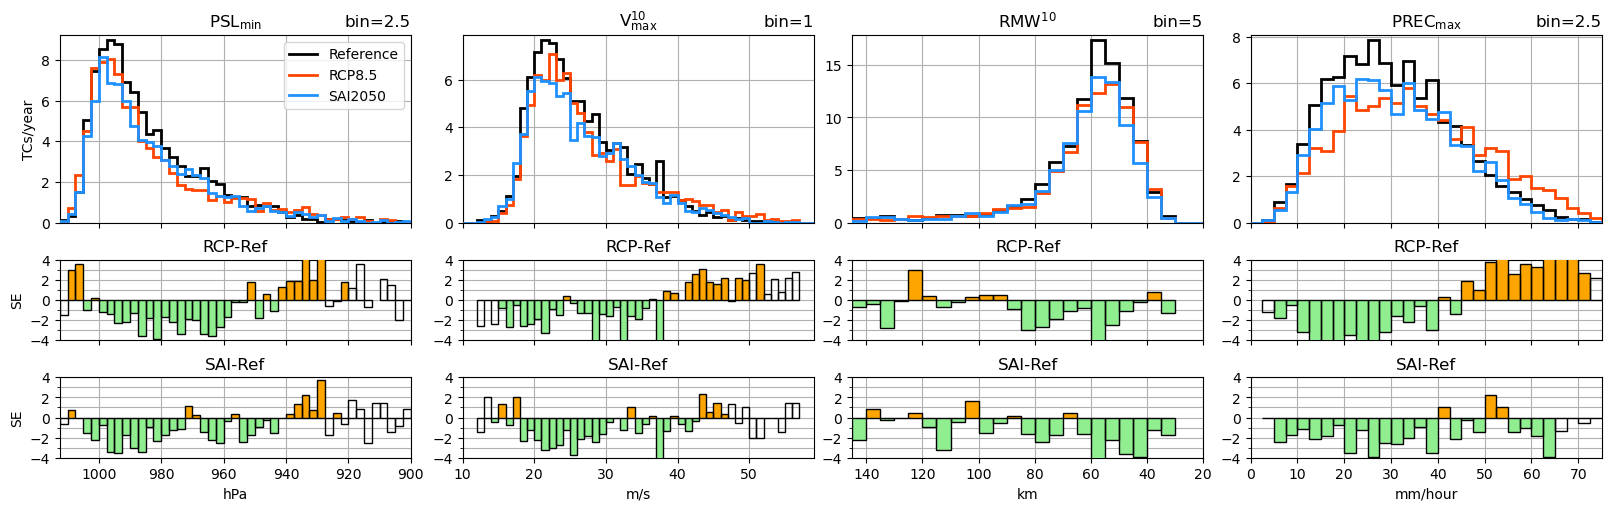

In [57]:
hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': 'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': 'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': 'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': 'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': 'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': '|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': 'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': '$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','RMW','PRECT'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

fname = f"figures/hist_{method}{'_SE' if yunits=='SE' else ''}.pdf"
fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

savefig(fig, fname, bbox_inches='tight', transparent=True)

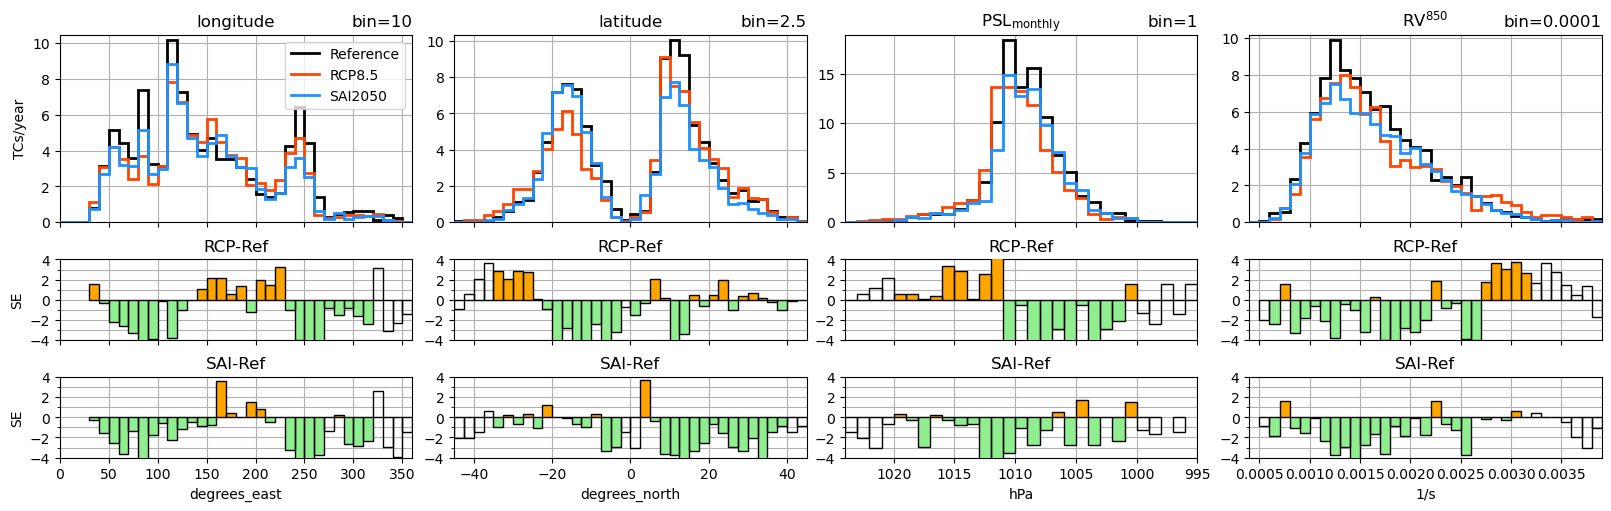

In [18]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['lon','lat','PSLmon','RV'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)


fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

#savefig(fig, f'figures/hist_{method}.pdf', bbox_inches='tight', transparent=True)

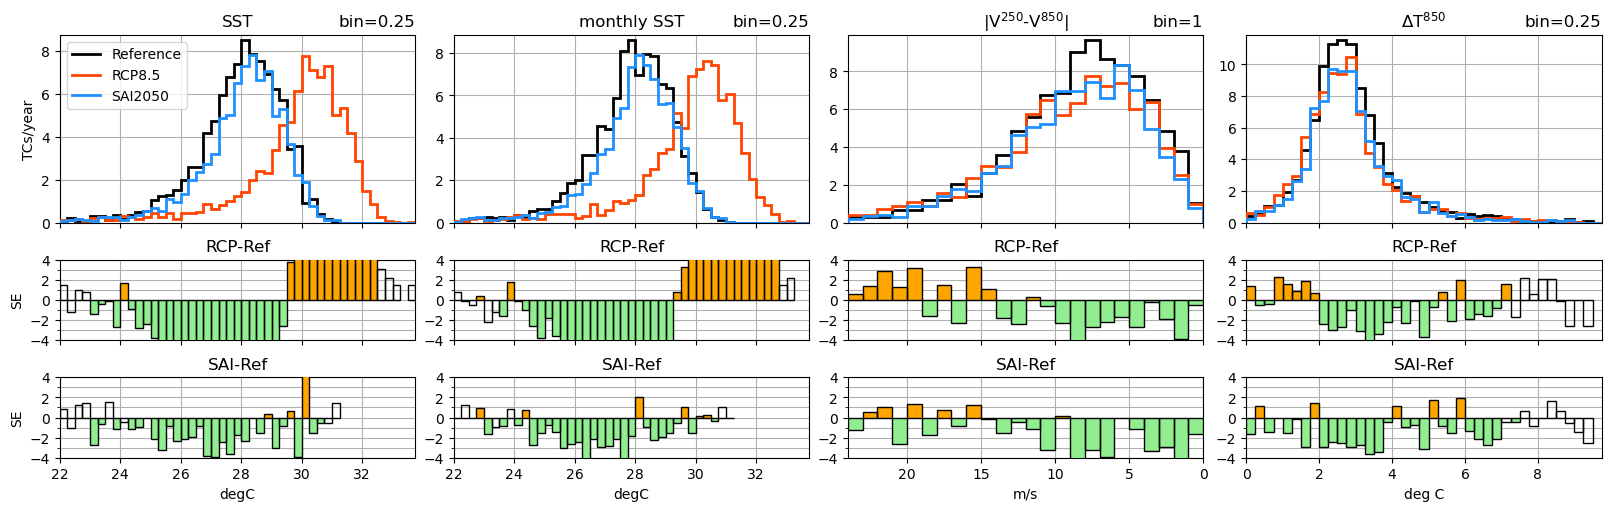

In [20]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['SST','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)


fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

#savefig(fig, f'figures/hist_{method}.pdf', bbox_inches='tight', transparent=True)

saving figures/hist_develop_SE.pdf...


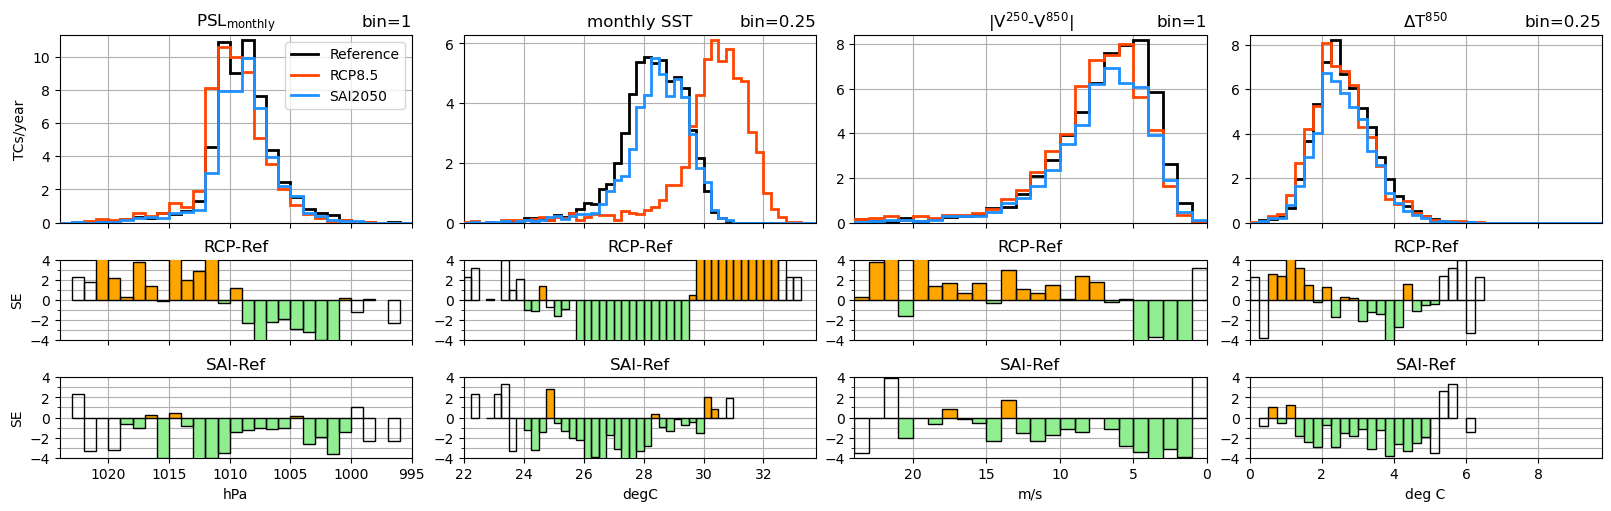

In [22]:
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'develop'         # reduction method (passed to track_stat)
plot_vars = ['PSLmon','SSTmon','Vshear','TEMP'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

fname = f"figures/hist_{method}{'_SE' if yunits=='SE' else ''}.pdf"
fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

savefig(fig, fname, bbox_inches='tight', transparent=True)

In [5]:
lons, lats, histCNT = track_density(ds['RCP8.5'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1))
lons, lats, histSAI = track_density(ds['SAI2050'], xbins=np.arange(0,360.1,1), ybins=np.arange(-90,90.1,1))
histCNT[np.isnan(histCNT)] = 0
histSAI[np.isnan(histSAI)] = 0
hist = histCNT + histSAI
hist[hist==0] = np.nan

figures/domains.pdf already exists, cannot overwrite


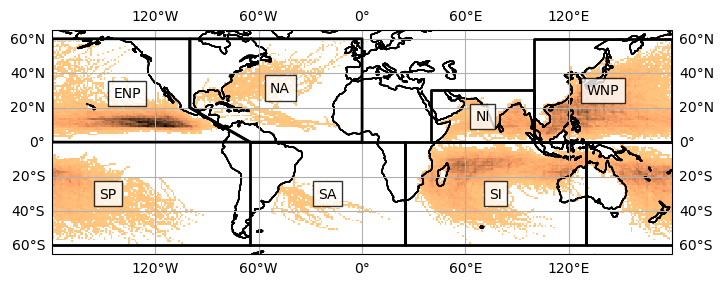

In [6]:
fname = 'figures/domains.pdf'
fig = plt.figure(figsize=(8,3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((-180,180,-65,65))
for dom in domains:
    ax.add_geometries(domains[dom], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, alpha=1, zorder=5)
    ax.text(domains[dom].centroid.x, domains[dom].centroid.y, dom, va='center', ha='center', transform=ccrs.PlateCarree(), 
            zorder=5, bbox=dict(facecolor='white', alpha=0.8))
    ax.coastlines()
    #ax.stock_img()
pcm = ax.pcolormesh(lons, lats, hist, transform=ccrs.PlateCarree(), vmin=None, vmax=None, cmap='copper_r', zorder=1)
ax.plot([-180,-65],[-60,-60], transform=ccrs.PlateCarree(), c='k', lw=2, zorder=5)
ax.gridlines(alpha=1, linestyle='-', draw_labels=True, zorder=4)

savefig(fig, fname, transparent=True, bbox_inches='tight')

In [49]:
dom = 'ENP'
select_region(ds['RCP8.5'], dom).PSL.quantile([0.01,0.5])

<xarray.DataArray 'PSL' (quantile: 2)> Size: 16B
array([ 973.72381592, 1002.97821045])
Coordinates:
  * quantile  (quantile) float64 16B 0.01 0.5

saving figures/regional/tracks_ENP.pdf...


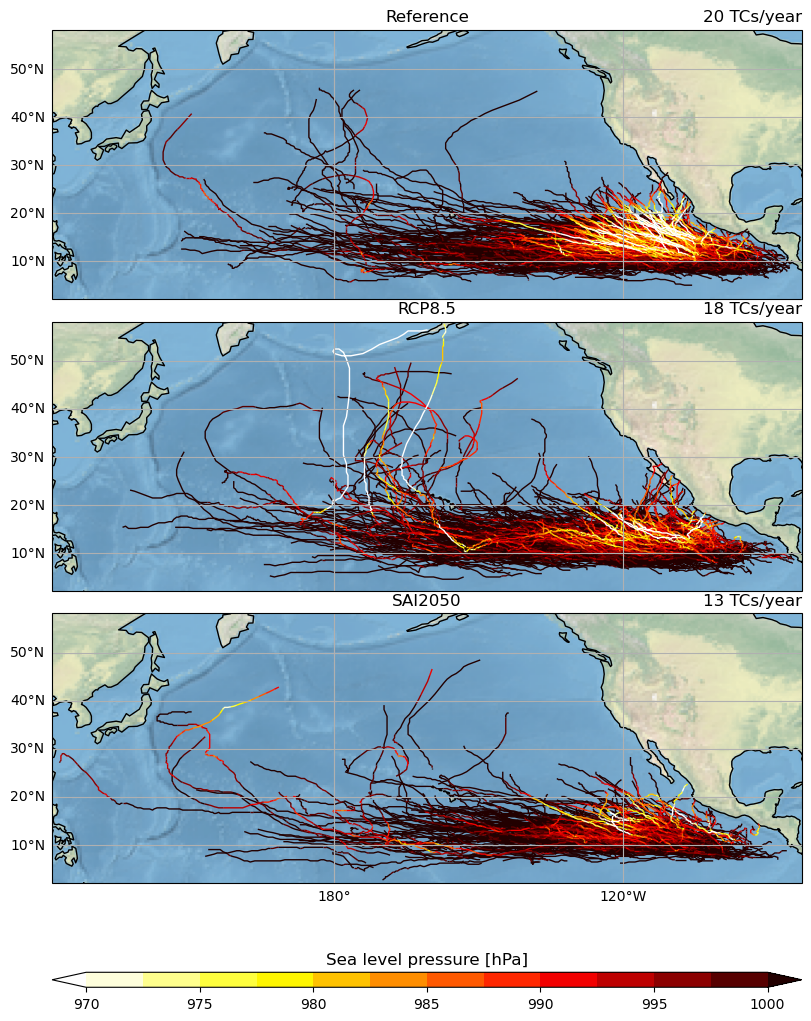

In [55]:
dom = 'ENP'


################### track figure #######################

fname = f'figures/regional/tracks_{dom}.pdf'
vmin, vmax = 970, 1000
Nv = round((vmax-vmin)/2.5)+1
clevels = np.linspace(vmin, vmax, Nv)
cmap = plt.get_cmap('hot_r')

fig,axs = plt.subplots(3,1,figsize=(8,10), constrained_layout=True, sharex=True, sharey=True,
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=domains[dom].centroid.x),
                                   'xmargin':0.01, 'ymargin':0.01})
for exp, ax in zip(ds, axs):
    dsi = select_region(ds[exp], dom)
    segments = track_segments(dsi, clevels)
    for clevid, segs in segments.items():
        color = cmap((clevid-0.5)/Nv)
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    ax.set_title(exp)
    ax.set_title(f'{dsi.id.size/ds[exp].num_days*365:.0f} TCs/year', loc='right')
    ax.coastlines()
    ax.gridlines(draw_labels=(['left','bottom'] if ax==axs[-1] else ['left']))

for ax in axs: # must be after plotting to prevent setting a global view
    ax.stock_img()

# create colorbar
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs, extend='both', orientation='horizontal', aspect=50, shrink=1)
cb.ax.set_title('Sea level pressure [hPa]')

savefig(fig, fname, transparent=True, bbox_inches='tight')

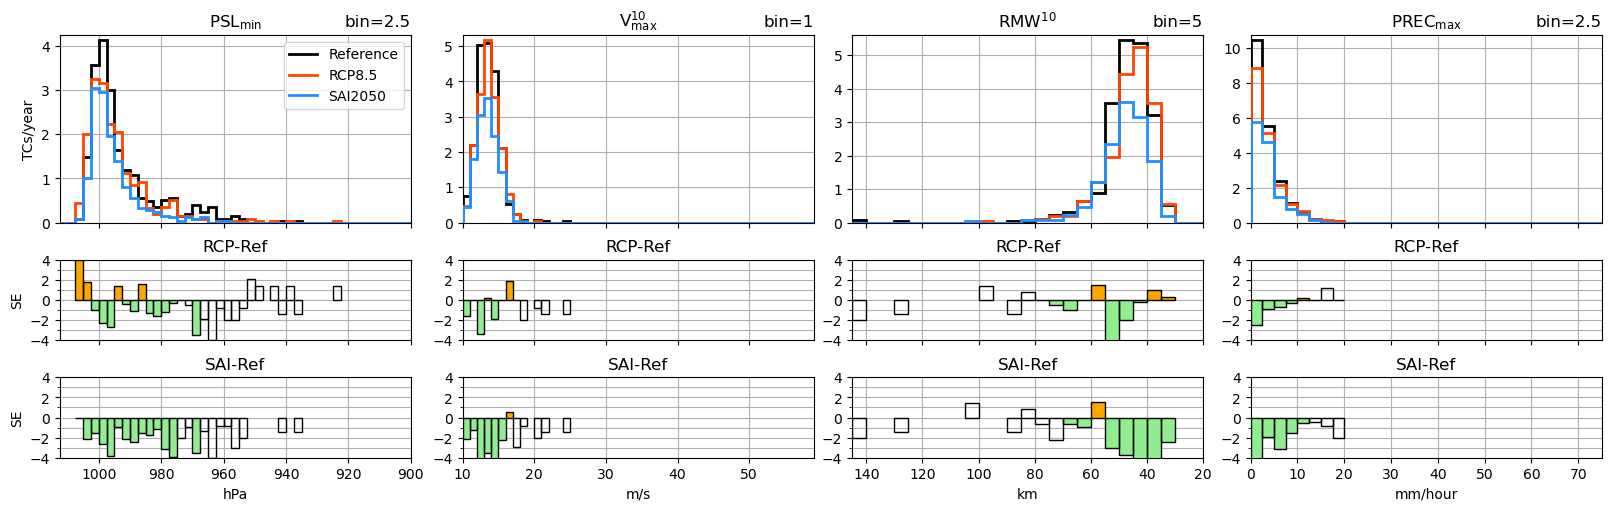

In [58]:
############## PSL, RMW, V, PREC figure @ max RV ######################

dom = 'ENP'
yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','RMW','PRECT'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': 'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': 'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': 'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': 'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': 'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': '|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': 'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': '$\Delta$T$^{850}$', 'rev':False},
}

fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(16,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

dsi = {exp: select_region(ds[exp], dom) for exp in ds}
dsi = {exp: track_stat(dsi[exp]) for exp in dsi}

for col,var in enumerate(plot_vars):
    hists = {exp: histogram(dsi[exp][var], hist_kwargs[var]['bins']) for exp in dsi}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

#savefig(fig, f'figures/regional/hist_{method}_{dom}.pdf', bbox_inches='tight', transparent=True)

figures/regional/hist_develop_SP.pdf already exists, cannot overwrite


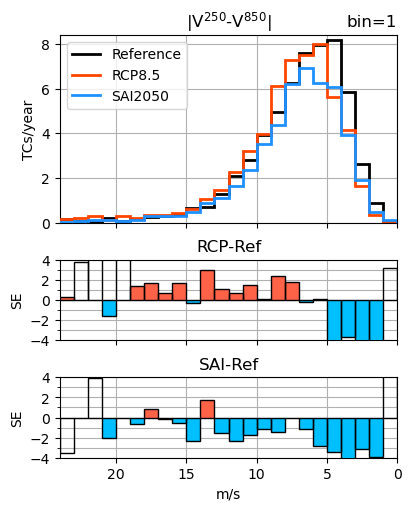

In [367]:
############### SHEAR figure #################

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
method = 'develop'         # reduction method (passed to track_stat)
plot_vars = ['Vshear'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

fig,axs = plt.subplots(3,1, height_ratios=(7,3,3), figsize=(4,5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))
axs = axs[:,np.newaxis]

ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

savefig(fig, f'figures/regional/hist_{method}_{dom}.pdf', bbox_inches='tight', transparent=True)

Text(0.5, 1.0, 'Bootstrapped')

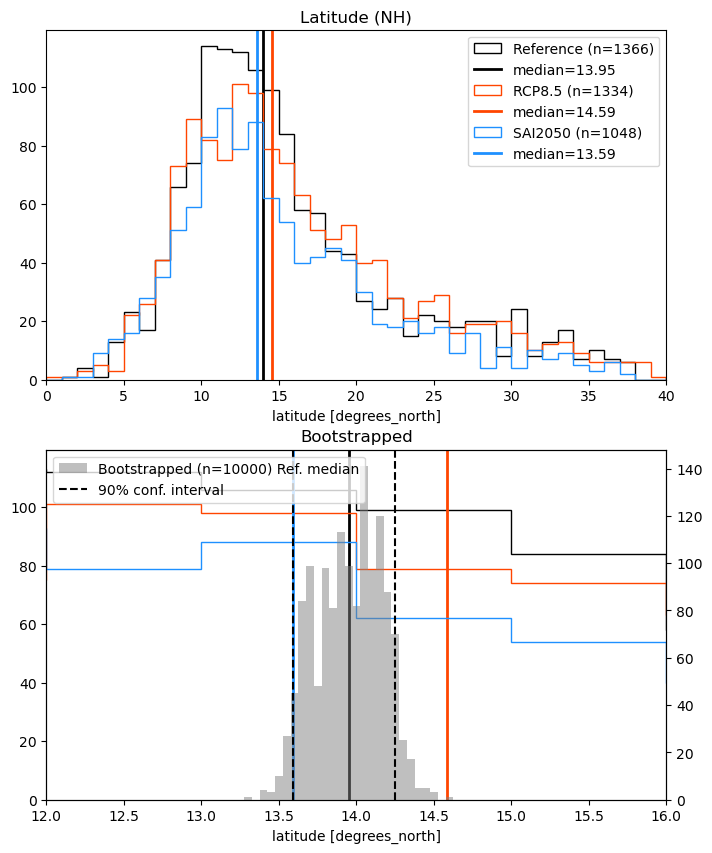

In [6]:
ds_stat = {method: {exp: track_stat(ds[exp], method) for exp in ds} 
           for method in ['mean','maxRV','develop','maxdeep']}
bins = np.arange(0,91)
fig, axs = plt.subplots(2,1, figsize=(8,10))
for exp in ds:
    lats = ds_stat['mean'][exp].lat
    lats_NH = lats.where(lats>=0, drop=True)
    lats_NH.plot.hist(ax=axs[0], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    lats_NH.plot.hist(ax=axs[1], bins=bins, histtype='step', **(default_kwargs[exp] | {'label':exp+f' (n={lats_NH.id.size})'}))
    axs[0].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
    axs[1].axvline(lats_NH.median(), **(default_kwargs[exp] | {'label':f"median={lats_NH.median():.2f}"}))
axs[0].legend()
axs[0].set_xlim([0,40])
axs[0].set_title('Latitude (NH)')

lats = ds_stat['mean']['Reference'].lat
lats_NH = lats.where(lats>=0, drop=True)
all_quants = bootstrap(lats_NH, np.quantile, [0.5], qs=np.linspace(0,1,len(lats_NH)))
confidence_lims2 = bootstrap(lats_NH, np.quantile, [0.5])

ax2 = axs[1].twinx()
hist,edges = np.histogram(all_quants, bins=np.arange(all_quants.min(),all_quants.max()+0.04, 0.05))
ax2.stairs(hist, fill=True, alpha=0.5, color='gray', edges=edges, label=f'Bootstrapped (n=10000) Ref. median')
ax2.axvline(confidence_lims2[0], c='k', ls='--', label='90% conf. interval')
ax2.axvline(confidence_lims2[1], c='k', ls='--')
ax2.legend()
axs[1].set_xlim([12,16])
axs[1].set_title('Bootstrapped') 